In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename.

    Defined in :numref:`sec_kaggle_house`"""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

(2919, 79)


In [4]:
numeric_index_matrix = all_features.dtypes[all_features.dtypes != "object"].index
all_features[numeric_index_matrix] = all_features[numeric_index_matrix].apply(lambda x:(x-x.mean()) / (x.std()))
all_features[numeric_index_matrix] = all_features[numeric_index_matrix].fillna(all_features[numeric_index_matrix].mean())

In [19]:
x = {"a":[1, 2, 3, None], "b":[4, None, 2, None]}
y = pd.DataFrame(x)
print(y)
print(y.fillna(y.mean()))

     a    b
0  1.0  4.0
1  2.0  NaN
2  3.0  2.0
3  NaN  NaN
     a    b
0  1.0  4.0
1  2.0  3.0
2  3.0  2.0
3  2.0  3.0


In [6]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

(2919, 331)


In [7]:
n_train = train_data.shape[0]

train_features = torch.tensor(all_features.iloc[:n_train, :].values, dtype = torch.float32)
test_features = torch.tensor(all_features.iloc[n_train:, :].values, dtype = torch.float32)
labels_features = torch.tensor(train_data.iloc[:n_train, -1].values, dtype = torch.float32).reshape(-1, 1)

print(train_features.shape)
print(test_features.shape)
print(labels_features.shape)

torch.Size([1460, 331])
torch.Size([1459, 331])
torch.Size([1460, 1])


In [8]:
loss = nn.MSELoss()

hidden_layers, dropout = 256, 0.5
class Net(nn.Module):
    def __init__(self, hidden_layers, dropout):
        super().__init__()
        self.hidden1 = nn.Linear(train_features.shape[-1], hidden_layers, bias=False)
        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_layers, 1, bias=False)
        
    def forward(self, X):
        X = self.hidden1(X)
        X = self.drop(X)
        X = self.relu(X)
        out = self.hidden2(X)
        return out
        
net = Net(hidden_layers, dropout)
net = nn.Linear(train_features.shape[-1], 1, bias=False)
print(net(train_features).shape)

torch.Size([1460, 1])


In [25]:
def log_rmse(net, features, labels):
    preds = torch.clamp(net(features), 1, float("inf"))
    rmse = torch.sqrt(loss(torch.log(preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, 
          epoch_nums, learning_rate, weight_decay, batch_size):
    train_loss, test_loss = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size=batch_size)
    if test_features is not None:
        test_iter = d2l.load_array((test_features, test_labels), batch_size=batch_size)
    optimizer = torch.optim.Adam(net.parameters(), weight_decay=weight_decay, lr=learning_rate)
    for epoch in range(epoch_nums):
        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        train_loss.append(log_rmse(net, train_features, train_labels))
        
        if test_labels is not None:
            test_loss.append(log_rmse(net, test_features, test_labels))
    
    return train_loss, test_loss

In [26]:
def get_k_fold_data(k, valid_index, X, y):
    assert type(X) == np.ndarray or type(X) == torch.Tensor, print(type(X))
    assert k > 1
    x_train, y_train = None, None
    x_valid, y_valid = None, None
    fold_size = X.shape[0] // k
    for i in range(k):
        idx = slice(i * fold_size, (i + 1) * fold_size)
        x_part, y_part = X[idx, :], y[idx]
        assert x_part.shape[1] == X.shape[1], print(x_part.shape[1], X.shape[1])
        if i == valid_index:
            x_valid, y_valid = x_part, y_part
        elif x_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat([x_train, x_part], dim = 0)
            y_train = torch.cat([y_train, y_part], dim = 0)
            
    return x_train, y_train, x_valid, y_valid

In [27]:
k = 5
for i in range(5):
    x_train, y_train, x_valid, y_valid = get_k_fold_data(k, i, train_features, labels_features)
    print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

torch.Size([1168, 331]) torch.Size([1168, 1]) torch.Size([292, 331]) torch.Size([292, 1])
torch.Size([1168, 331]) torch.Size([1168, 1]) torch.Size([292, 331]) torch.Size([292, 1])
torch.Size([1168, 331]) torch.Size([1168, 1]) torch.Size([292, 331]) torch.Size([292, 1])
torch.Size([1168, 331]) torch.Size([1168, 1]) torch.Size([292, 331]) torch.Size([292, 1])
torch.Size([1168, 331]) torch.Size([1168, 1]) torch.Size([292, 331]) torch.Size([292, 1])


In [28]:
def k_fold_train(k, X_train, y_train, num_epochs, 
                 learning_rate, weight_decay, batch_size):
    train_loss_sum, valid_loss_sum = 0, 0
    for i in range(k):
        datas = get_k_fold_data(k, i, X_train, y_train)
        train_loss, test_loss = train(net, *datas, num_epochs, learning_rate, weight_decay, batch_size)
        train_loss_sum += train_loss[-1]
        valid_loss_sum += test_loss[-1]
        assert len(train_loss) == num_epochs, print(len(train_loss))
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_loss, test_loss], 
                     xlabel='epoch', ylabel='rmse', legend=["train", "valid"], 
                     xlim=[1, num_epochs], yscale='log')
            
        print(f"fold {i + 1}, train_loss {float(train_loss[-1])} and valid_loss {float(test_loss[-1])}")
    
    return train_loss_sum / k, valid_loss_sum / k

fold 1, train_loss 2.1220829486846924 and valid_loss 2.1381406784057617
fold 2, train_loss 1.436302900314331 and valid_loss 1.4443827867507935
fold 3, train_loss 1.0374723672866821 and valid_loss 1.0492498874664307
fold 4, train_loss 0.7661495208740234 and valid_loss 0.7442811727523804
fold 5, train_loss 0.552629292011261 and valid_loss 0.5521432161331177


(1.182927405834198, 1.1856395483016968)

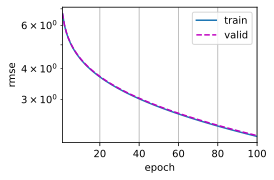

In [13]:
num_epochs, learning_rate, weight_decay, batch_size = 100, 1, 0, 256
k_fold_train(k, train_features, labels_features, num_epochs, learning_rate, weight_decay, batch_size)

In [35]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, 
                 learning_rate, weight_decay, batch_size):
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, learning_rate, weight_decay, batch_size)
    d2l.plot(list(range(1, num_epochs + 1)), [train_ls], 
                     xlabel='epoch', ylabel='log rmse', legend=["train"], 
                     xlim=[1, num_epochs], yscale='log')
    print(f"fold {i + 1}, train_loss {float(train_ls[-1])}.")
    preds = net(test_features).detach().numpy()
    test_data["SalePrice"] = pd.Series(preds.reshape(1, -11)[0])
    submission = pd.concat([test_data["Id"], test_data["SalePrice"]], axis=1)
    submission.to_csv("submission.csv", index=False)

fold 5, train_loss 0.18413609266281128.


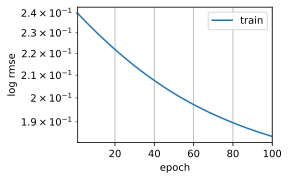

In [36]:
train_and_pred(train_features, test_features, labels_features, test_data, num_epochs, learning_rate, weight_decay, batch_size)